#### Model Development (Part 1: ResNet50)


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # Import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # Layers for the head
from tensorflow.keras.models import Model # To combine base and head
from tensorflow.keras.optimizers import Adam # Optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Callbacks for training
import os # For file paths if needed later

print("Libraries for model building imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries for model building imported successfully!
TensorFlow version: 2.20.0


In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 2 # Normal (0) or TB (1)
SEED = 42 # For reproducibility if needed for layers

# Load the pre-trained ResNet50 model, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# Note: Input shape is (256, 256, 3) even though our processed images are (256, 256, 1).
# We will handle the channel difference later or adjust the base model input if necessary.
# ResNet50 expects 3-channel input. Our grayscale images were loaded as 1-channel.
# We might need to repeat the channel or load them as 3-channel initially.
# Let's modify the input layer of the base model to accept 1-channel input.
# Option 1: Modify input layer (more complex)
# Option 2: In the EDA notebook, ensure images are loaded as 3-channel (e.g., by removing the cv2.cvtColor to grayscale and keeping BGR/RGB).
# Let's try Option 2: Modify the EDA notebook's loading function to keep 3 channels, then reload data here.
# Actually, let's try Option 3: Use tf.keras.layers.RepeatVector or similar within the model to expand the channel.

# For now, let's assume we load images as 3-channel in the EDA notebook.
# If your EDA notebook loaded images as (256, 256, 1), we need to adjust.
# Let's create the model expecting (256, 256, 1) and add a layer to convert it to 3 channels internally.
# Or, let's go back to the EDA notebook and ensure images are loaded as 3-channel (RGB).

# Revisiting the EDA notebook loading function might be best.
# However, for now, let's try creating a model that takes 1-channel input and internally handles it.
# We can use a Lambda layer or similar to repeat the channel.
# Let's create the model expecting 1-channel input from the EDA notebook and add a layer to make it 3-channel for ResNet50.

from tensorflow.keras.layers import Input, Lambda
import tensorflow.keras.backend as K

# Define input for 1-channel grayscale images
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='input_layer')

# Function to repeat the channel 3 times (for RGB)
def repeat_channels(x):
    return K.repeat_elements(x, 3, axis=-1) # Repeat the last axis (channel) 3 times

# Apply the channel repeating function
x = Lambda(repeat_channels)(input_layer)

# Now load ResNet50 with 3-channel input, but connect it to the repeated output
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We need to connect 'x' to the base_model now.
# A cleaner way: Build the model sequentially.
base_model_out = base_model(x) # Connect the repeated layer to base model

# Add custom head layers
x = GlobalAveragePooling2D()(base_model_out) # Pool features
x = Dropout(0.5)(x) # Add dropout for regularization
# Output layer for binary classification
predictions = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # Use 'sigmoid' if 1 neuron, 'softmax' if 2 neurons

# Create the final model
model_resnet50 = Model(inputs=input_layer, outputs=predictions)

print("ResNet50 base model loaded and custom head added.")
print(f"Model input shape: {model_resnet50.input_shape}")
print(f"Model output shape: {model_resnet50.output_shape}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

ResNet50 base model loaded and custom head added.
Model input shape: (None, 256, 256, 1)
Model output shape: (None, 2)


In [3]:
# Freeze the base model layers
base_model.trainable = False

print(f"Number of layers in the base model: {len(base_model.layers)}")
print("Base model layers frozen.")

Number of layers in the base model: 175
Base model layers frozen.


In [4]:
# Compile the model
model_resnet50.compile(
    optimizer=Adam(learning_rate=0.001), # Starting learning rate
    loss='sparse_categorical_crossentropy', # Use 'sparse' because labels are integers (0, 1)
    metrics=['accuracy']
)

# Print model summary
model_resnet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Define callbacks
# Save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='models/model_resnet50_best.h5', # Path to save the best model
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Stop training if validation accuracy doesn't improve for a certain number of epochs
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

In [11]:
# Train the model
# Note: We use sparse_categorical_crossentropy because our labels are integers (0, 1)
history = model_resnet50.fit(
    train_dataset,
    epochs=50, # You can adjust the number of epochs
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1 # Set to 2 for more detailed output per epoch
)

print("Model training completed!")

Epoch 1/50


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8096 - loss: 0.5255
Epoch 1: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8204 - loss: 0.4936 - val_accuracy: 0.8289 - val_loss: 0.4490
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8214 - loss: 0.4921
Epoch 2: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.8293 - loss: 0.4725 - val_accuracy: 0.8289 - val_loss: 0.4478
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8171 - loss: 0.4834
Epoch 3: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8276 - loss: 0.4697 - val_accuracy: 0.8289 - val_loss: 0.4412
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8218 - loss: 0.4817
Epoch 4: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8298 - loss: 0.4623 - val_accuracy: 0.8289 - val_loss: 0.4330
Epoch 5/50


In [11]:
# Define image size and batch size
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32 # You can adjust this based on your memory constraints
SEED = 42 # For reproducible shuffling

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define image size and batch size
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32 # You can adjust this based on your memory constraints
SEED = 42 # For reproducible shuffling

# Define a Python function to load and preprocess image using OpenCV
# Fixes the label dtype issue
def load_and_preprocess_image_cv2_fixed(path_str, label):
    # Convert path from tensor to string
    path = path_str.numpy().decode('utf-8') # Decode bytes to string
    # Load image using OpenCV (loads as BGR)
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"Failed to read image at path: {path}")
    # Convert BGR to RGB (optional, but often done for consistency with matplotlib)
    # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # For grayscale X-rays, we can convert to grayscale or keep as BGR/RGB
    # Let's convert to grayscale for simplicity and consistency with typical X-ray processing
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Resize to target dimensions
    img_resized = cv2.resize(img_gray, (IMG_WIDTH, IMG_HEIGHT))
    # Normalize pixel values to [0, 1]
    img_normalized = img_resized.astype(np.float32) / 255.0
    # Add channel dimension (for CNN input, shape should be [height, width, channels])
    img_final = np.expand_dims(img_normalized, axis=-1) # Shape becomes (256, 256, 1)

    # *** CRUCIAL FIX: Cast the label to numpy.int32 ***
    label_out = np.array(label.numpy(), dtype=np.int32)

    return img_final, label_out

# Wrap the FIXED Python function in a TensorFlow-compatible function using tf.py_function
def tf_load_and_preprocess_image_fixed(path, label):
    # Use tf.py_function to call the Python function
    # Note: tf.py_function returns tensors, so we need to specify output shapes and types
    image, label_out = tf.py_function(
        func=load_and_preprocess_image_cv2_fixed,
        inp=[path, label],
        Tout=[tf.float32, tf.int32] # Output types: float32 for image, int32 for label
    )
    # Set the shape of the output tensors explicitly
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 1]) # Set shape for the image tensor
    label_out.set_shape([]) # Set shape for the scalar label tensor
    return image, label_out

# Load the entire dataset paths and labels
# Adjust the path if your dataset folder has a different name
data_dir = os.path.join('..', 'data', 'tuberculosis-chest-xrays-images')

# Prepare lists for image paths and labels
image_paths = []
labels = []

# Iterate through Normal and Tuberculosis folders
for class_name in ['Normal', 'Tuberculosis']: # Adjust folder names if necessary
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image_paths.append(img_path)
        labels.append(1 if class_name == 'Tuberculosis' else 0) # 1 for TB, 0 for Normal

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total images loaded: {len(image_paths)}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels and counts: {np.unique(labels, return_counts=True)}")

# Split the data into train+validation and test sets (e.g., 80% train+val, 20% test)
# Use stratify=labels to maintain class distribution
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# Now, split the train+validation set into train and validation sets (e.g., 75% of 80% = 60% train, 25% of 80% = 20% val)
# Or simply: split train_val into 75% train, 25% val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.25, random_state=SEED, stratify=train_val_labels # 0.25 * 0.8 = 0.2 for val
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"Training label distribution: {dict(zip(*np.unique(train_labels, return_counts=True)))}")
print(f"Validation label distribution: {dict(zip(*np.unique(val_labels, return_counts=True)))}")
print(f"Test label distribution: {dict(zip(*np.unique(test_labels, return_counts=True)))}")

# Create tf.data.Dataset from the split paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Apply the FIXED preprocessing function using tf.py_function wrapper
train_dataset = train_dataset.map(tf_load_and_preprocess_image_fixed, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(tf_load_and_preprocess_image_fixed, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(tf_load_and_preprocess_image_fixed, num_parallel_calls=tf.data.AUTOTUNE)

# Set batch size and configure for performance (optional but recommended)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets created successfully (in 02_model_training notebook)!")
print(f"Train dataset element spec: {train_dataset.element_spec}")
print(f"Validation dataset element spec: {val_dataset.element_spec}")
print(f"Test dataset element spec: {test_dataset.element_spec}")

# Optional: Print a batch of images and labels to verify (this should now work)
print("\nSample batch from training dataset:")
for images, labels in train_dataset.take(1):
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    print(f"Sample labels in batch: {labels[:5].numpy()}") # Print first 5 labels
    break # Only take one batch

Total images loaded: 3008
Labels shape: (3008,)
Unique labels and counts: (array([0, 1]), array([ 514, 2494]))
Training samples: 1804
Validation samples: 602
Test samples: 602
Training label distribution: {np.int64(0): np.int64(308), np.int64(1): np.int64(1496)}
Validation label distribution: {np.int64(0): np.int64(103), np.int64(1): np.int64(499)}
Test label distribution: {np.int64(0): np.int64(103), np.int64(1): np.int64(499)}
Datasets created successfully (in 02_model_training notebook)!
Train dataset element spec: (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset element spec: (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Test dataset element spec: (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Sample batch from training dataset:
Batch imag

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # Import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Lambda # Layers for the head
from tensorflow.keras.models import Model # To combine base and head
from tensorflow.keras.optimizers import Adam # Optimizer
import tensorflow.keras.backend as K # For the Lambda layer function

# Define input for 1-channel grayscale images
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='input_layer')

# Function to repeat the channel 3 times (for RGB)
def repeat_channels(x):
    return K.repeat_elements(x, 3, axis=-1) # Repeat the last axis (channel) 3 times

# Apply the channel repeating function
x = Lambda(repeat_channels)(input_layer)

# Now load ResNet50 with 3-channel input, but connect it to the repeated output
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We need to connect 'x' to the base_model now.
base_model_out = base_model(x) # Connect the repeated layer to base model

# Add custom head layers
x = GlobalAveragePooling2D()(base_model_out) # Pool features
x = Dropout(0.5)(x) # Add dropout for regularization
# Output layer for binary classification (2 classes: Normal, TB)
predictions = Dense(2, activation='softmax', name='predictions')(x) # Use 'softmax' for 2 neurons

# Create the final model
model_resnet50 = Model(inputs=input_layer, outputs=predictions)

# Freeze the base model layers
base_model.trainable = False

print(f"Number of layers in the base model: {len(base_model.layers)}")
print("Base model layers frozen.")

# Compile the model
model_resnet50.compile(
    optimizer=Adam(learning_rate=0.001), # Starting learning rate
    loss='sparse_categorical_crossentropy', # Use 'sparse' because labels are integers (0, 1)
    metrics=['accuracy']
)

# Print model summary
model_resnet50.summary()

Number of layers in the base model: 175
Base model layers frozen.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Callbacks for training

# Define callbacks
# Ensure the 'models' directory exists to save the model
os.makedirs('models', exist_ok=True)

# Save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='models/model_resnet50_best.h5', # Path to save the best model
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Stop training if validation accuracy doesn't improve for a certain number of epochs
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

In [18]:
# Train the model
# Note: We use sparse_categorical_crossentropy because our labels are integers (0, 1)
history = model_resnet50.fit(
    train_dataset,
    epochs=50, # You can adjust the number of epochs
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1 # Set to 2 for more detailed output per epoch
)

print("Model training completed!")

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7282 - loss: 0.6855
Epoch 1: val_accuracy improved from None to 0.82890, saving model to models/model_resnet50_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7882 - loss: 0.5806 - val_accuracy: 0.8289 - val_loss: 0.4569
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8118 - loss: 0.4911
Epoch 2: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8232 - loss: 0.4769 - val_accuracy: 0.8289 - val_loss: 0.4499
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8178 - loss: 0.4998
Epoch 3: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8265 - loss: 0.4812 - val_accuracy: 0.8289 - val_loss: 0.4468
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8209 - loss: 0.4867
Epoch 4: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8287 - loss: 0.4686 - val_accuracy: 0.8289 - val_loss: 0.4404
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8209 - loss: 0.4659
Epoch 5: val_accuracy did not improve from 0.82890


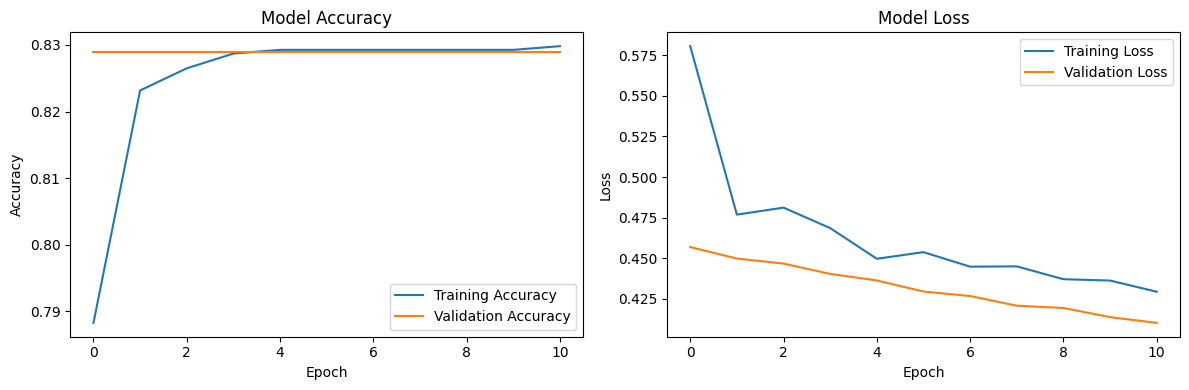

In [19]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Define the custom function again (needed for loading models saved with Lambda layer)
def repeat_channels(x):
    return K.repeat_elements(x, 3, axis=-1) # Repeat the last axis (channel) 3 times

# Load the best saved model, providing the custom function
best_model = tf.keras.models.load_model('models/model_resnet50_best.h5', custom_objects={'repeat_channels': repeat_channels})

# Evaluate the best model on the test set
# Make sure you have loaded test_dataset from 01_eda_tb_detection.ipynb first
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8289 - loss: 0.4570

Test Loss: 0.4569896161556244
Test Accuracy: 0.8289036750793457


In [10]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Define the custom function again
def repeat_channels(x):
    return K.repeat_elements(x, 3, axis=-1) # Repeat the last axis (channel) 3 times

# Load the best saved model, providing the custom function
best_model = tf.keras.models.load_model('models/model_resnet50_best.h5', custom_objects={'repeat_channels': repeat_channels})

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8289 - loss: 0.4560

Test Loss: 0.4560204744338989
Test Accuracy: 0.8289036750793457


In [11]:
from tensorflow.keras.applications import VGG16 # Import VGG16

# --- Define the VGG16-based model ---
# Use the same input layer and channel repeating logic as ResNet50
input_layer_vgg = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='input_layer_vgg')
x_vgg = Lambda(repeat_channels)(input_layer_vgg)

# Load VGG16 base model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model_vgg_out = base_model_vgg(x_vgg)

# Add custom head (similar structure to ResNet50)
x_vgg = GlobalAveragePooling2D()(base_model_vgg_out) # Pool features
x_vgg = Dropout(0.5)(x_vgg) # Add dropout for regularization
predictions_vgg = Dense(2, activation='softmax', name='predictions_vgg')(x_vgg) # Output layer

# Create the VGG16 model
model_vgg16 = Model(inputs=input_layer_vgg, outputs=predictions_vgg)

# Freeze the VGG16 base
base_model_vgg.trainable = False

print("VGG16 base model loaded and custom head added.")
print(f"VGG16 Model input shape: {model_vgg16.input_shape}")
print(f"VGG16 Model output shape: {model_vgg16.output_shape}")

# Compile the VGG16 model
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print VGG16 model summary
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
VGG16 base model loaded and custom head added.
VGG16 Model input shape: (None, 256, 256, 1)
VGG16 Model output shape: (None, 2)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_vgg (InputLayer)    │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions_vgg (Dense)         │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Define callbacks for VGG16
checkpoint_callback_vgg = ModelCheckpoint(
    filepath='models/model_vgg16_best.h5', # Different path
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback_vgg = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#### Train the VGG16 Model

In [13]:
# Train the VGG16 model
history_vgg = model_vgg16.fit(
    train_dataset, # Use the same training data
    epochs=50,
    validation_data=val_dataset, # Use the same validation data
    callbacks=[checkpoint_callback_vgg, early_stopping_callback_vgg],
    verbose=1
)

print("VGG16 model training completed!")

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5828 - loss: 0.7171
Epoch 1: val_accuracy improved from None to 0.82890, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.7406 - loss: 0.5461 - val_accuracy: 0.8289 - val_loss: 0.4207
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8219 - loss: 0.4304
Epoch 2: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 338s 6s/step - accuracy: 0.8298 - loss: 0.4056 - val_accuracy: 0.8289 - val_loss: 0.3580
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8246 - loss: 0.3754
Epoch 3: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 328s 6s/step - accuracy: 0.8359 - loss: 0.3531 - val_accuracy: 0.8289 - val_loss: 0.3089
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8481 - loss: 0.3173
Epoch 4: val_accuracy improved from 0.82890 to 0.84219, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.8525 - loss: 0.3092 - val_accuracy: 0.8422 - val_loss: 0.2747
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8599 - loss: 0.2941
Epoch 5: val_accuracy improved from 0.84219 to 0.88538, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.8725 - loss: 0.2806 - val_accuracy: 0.8854 - val_loss: 0.2480
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8796 - loss: 0.2730
Epoch 6: val_accuracy improved from 0.88538 to 0.90033, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 348s 6s/step - accuracy: 0.8858 - loss: 0.2607 - val_accuracy: 0.9003 - val_loss: 0.2283
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8892 - loss: 0.2480
Epoch 7: val_accuracy improved from 0.90033 to 0.91860, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.8908 - loss: 0.2445 - val_accuracy: 0.9186 - val_loss: 0.2124
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9033 - loss: 0.2357
Epoch 8: val_accuracy improved from 0.91860 to 0.92857, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 355s 6s/step - accuracy: 0.9002 - loss: 0.2321 - val_accuracy: 0.9286 - val_loss: 0.1996
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9220 - loss: 0.2188
Epoch 9: val_accuracy improved from 0.92857 to 0.93522, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step - accuracy: 0.9235 - loss: 0.2180 - val_accuracy: 0.9352 - val_loss: 0.1888
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9163 - loss: 0.2043
Epoch 10: val_accuracy improved from 0.93522 to 0.93854, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.9152 - loss: 0.2055 - val_accuracy: 0.9385 - val_loss: 0.1794
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9344 - loss: 0.1915
Epoch 11: val_accuracy improved from 0.93854 to 0.94186, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 337s 6s/step - accuracy: 0.9285 - loss: 0.1940 - val_accuracy: 0.9419 - val_loss: 0.1715
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9220 - loss: 0.1951
Epoch 12: val_accuracy did not improve from 0.94186
57/57 ━━━━━━━━━━━━━━━━━━━━ 335s 6s/step - accuracy: 0.9274 - loss: 0.1920 - val_accuracy: 0.9402 - val_loss: 0.1642
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9291 - loss: 0.1922
Epoch 13: val_accuracy improved from 0.94186 to 0.94352, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.9257 - loss: 0.1896 - val_accuracy: 0.9435 - val_loss: 0.1582
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9414 - loss: 0.1774
Epoch 14: val_accuracy improved from 0.94352 to 0.95183, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 342s 6s/step - accuracy: 0.9379 - loss: 0.1774 - val_accuracy: 0.9518 - val_loss: 0.1526
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9364 - loss: 0.1728
Epoch 15: val_accuracy did not improve from 0.95183
57/57 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.9390 - loss: 0.1733 - val_accuracy: 0.9518 - val_loss: 0.1477
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9444 - loss: 0.1623
Epoch 16: val_accuracy improved from 0.95183 to 0.95349, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 326s 6s/step - accuracy: 0.9390 - loss: 0.1676 - val_accuracy: 0.9535 - val_loss: 0.1431
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9342 - loss: 0.1632
Epoch 17: val_accuracy improved from 0.95349 to 0.95681, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.9401 - loss: 0.1660 - val_accuracy: 0.9568 - val_loss: 0.1391
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9437 - loss: 0.1623
Epoch 18: val_accuracy did not improve from 0.95681
57/57 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.9385 - loss: 0.1638 - val_accuracy: 0.9568 - val_loss: 0.1351
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9377 - loss: 0.1613
Epoch 19: val_accuracy improved from 0.95681 to 0.95847, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9407 - loss: 0.1631 - val_accuracy: 0.9585 - val_loss: 0.1317
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9440 - loss: 0.1573
Epoch 20: val_accuracy improved from 0.95847 to 0.96013, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9429 - loss: 0.1570 - val_accuracy: 0.9601 - val_loss: 0.1283
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9453 - loss: 0.1454
Epoch 21: val_accuracy did not improve from 0.96013
57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9424 - loss: 0.1520 - val_accuracy: 0.9601 - val_loss: 0.1252
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9560 - loss: 0.1408
Epoch 22: val_accuracy improved from 0.96013 to 0.96346, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9551 - loss: 0.1435 - val_accuracy: 0.9635 - val_loss: 0.1223
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9445 - loss: 0.1503
Epoch 23: val_accuracy improved from 0.96346 to 0.96512, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9462 - loss: 0.1491 - val_accuracy: 0.9651 - val_loss: 0.1197
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9426 - loss: 0.1521
Epoch 24: val_accuracy did not improve from 0.96512
57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9457 - loss: 0.1484 - val_accuracy: 0.9601 - val_loss: 0.1174
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9460 - loss: 0.1461
Epoch 25: val_accuracy did not improve from 0.96512
57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9484 - loss: 0.1464 - val_accuracy: 0.9635 - val_loss: 0.1150
Epoch 26/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9542 - loss: 0.1423
Epoch 26: val_accuracy improved from 0.96512 to 0.96678, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.9545 - loss: 0.1425 - val_accuracy: 0.9668 - val_loss: 0.1129
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9572 - loss: 0.1295
Epoch 27: val_accuracy improved from 0.96678 to 0.96844, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9529 - loss: 0.1374 - val_accuracy: 0.9684 - val_loss: 0.1110
Epoch 28/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9597 - loss: 0.1275
Epoch 28: val_accuracy did not improve from 0.96844
57/57 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.9534 - loss: 0.1321 - val_accuracy: 0.9668 - val_loss: 0.1088
Epoch 29/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9603 - loss: 0.1224
Epoch 29: val_accuracy did not improve from 0.96844
57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9590 - loss: 0.1259 - val_accuracy: 0.9684 - val_loss: 0.1068
Epoch 30/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9557 - loss: 0.1288
Epoch 30: val_accuracy improved from 0.96844 to 0.97010, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.9557 - loss: 0.1277 - val_accuracy: 0.9701 - val_loss: 0.1050
Epoch 31/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9641 - loss: 0.1238
Epoch 31: val_accuracy did not improve from 0.97010
57/57 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9595 - loss: 0.1294 - val_accuracy: 0.9701 - val_loss: 0.1029
Epoch 32/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9595 - loss: 0.1194
Epoch 32: val_accuracy improved from 0.97010 to 0.97176, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9595 - loss: 0.1209 - val_accuracy: 0.9718 - val_loss: 0.1013
Epoch 33/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9588 - loss: 0.1231
Epoch 33: val_accuracy did not improve from 0.97176
57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9601 - loss: 0.1221 - val_accuracy: 0.9701 - val_loss: 0.0997
Epoch 34/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9622 - loss: 0.1161
Epoch 34: val_accuracy did not improve from 0.97176
57/57 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9623 - loss: 0.1193 - val_accuracy: 0.9684 - val_loss: 0.0982
Epoch 35/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9566 - loss: 0.1138
Epoch 35: val_accuracy did not improve from 0.97176
57/57 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.9551 - loss: 0.1189 - val_accuracy: 0.9718 - val_loss: 0.0963
Epoch 36/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9553 - loss: 0.1181
Epoch 36: val_accuracy improved from 0.97176

57/57 ━━━━━━━━━━━━━━━━━━━━ 318s 6s/step - accuracy: 0.9573 - loss: 0.1205 - val_accuracy: 0.9734 - val_loss: 0.0949
Epoch 37/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9595 - loss: 0.1121
Epoch 37: val_accuracy improved from 0.97342 to 0.97508, saving model to models/model_vgg16_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 410s 7s/step - accuracy: 0.9584 - loss: 0.1171 - val_accuracy: 0.9751 - val_loss: 0.0938
Epoch 38/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9561 - loss: 0.1132
Epoch 38: val_accuracy did not improve from 0.97508
57/57 ━━━━━━━━━━━━━━━━━━━━ 431s 8s/step - accuracy: 0.9612 - loss: 0.1147 - val_accuracy: 0.9751 - val_loss: 0.0925
Epoch 39/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9621 - loss: 0.1138
Epoch 39: val_accuracy did not improve from 0.97508
57/57 ━━━━━━━━━━━━━━━━━━━━ 377s 7s/step - accuracy: 0.9557 - loss: 0.1174 - val_accuracy: 0.9751 - val_loss: 0.0915
Epoch 40/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9523 - loss: 0.1202
Epoch 40: val_accuracy did not improve from 0.97508
57/57 ━━━━━━━━━━━━━━━━━━━━ 368s 6s/step - accuracy: 0.9573 - loss: 0.1097 - val_accuracy: 0.9751 - val_loss: 0.0899
Epoch 41/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9578 - loss: 0.1101
Epoch 41: val_accuracy did not improve from 

57/57 ━━━━━━━━━━━━━━━━━━━━ 324s 6s/step - accuracy: 0.9595 - loss: 0.1171 - val_accuracy: 0.9767 - val_loss: 0.0884
Epoch 43/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9569 - loss: 0.1147
Epoch 43: val_accuracy did not improve from 0.97674
57/57 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 0.9584 - loss: 0.1181 - val_accuracy: 0.9751 - val_loss: 0.0867
Epoch 44/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9576 - loss: 0.1207
Epoch 44: val_accuracy did not improve from 0.97674
57/57 ━━━━━━━━━━━━━━━━━━━━ 362s 6s/step - accuracy: 0.9562 - loss: 0.1242 - val_accuracy: 0.9767 - val_loss: 0.0863
Epoch 45/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9654 - loss: 0.1020
Epoch 45: val_accuracy did not improve from 0.97674
57/57 ━━━━━━━━━━━━━━━━━━━━ 385s 7s/step - accuracy: 0.9651 - loss: 0.1049 - val_accuracy: 0.9751 - val_loss: 0.0849
Epoch 46/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9621 - loss: 0.1162
Epoch 46: val_accuracy did not improve from 

In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Define the custom function again (needed for loading)
def repeat_channels(x):
    return K.repeat_elements(x, 3, axis=-1)

# Load the best saved VGG16 model
best_model_vgg = tf.keras.models.load_model('models/model_vgg16_best.h5', custom_objects={'repeat_channels': repeat_channels})

# Evaluate the best VGG16 model on the test set
test_loss_vgg, test_accuracy_vgg = best_model_vgg.evaluate(test_dataset, verbose=1)
print(f"\nVGG16 Test Loss: {test_loss_vgg}")
print(f"VGG16 Test Accuracy: {test_accuracy_vgg}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9767 - loss: 0.0866

VGG16 Test Loss: 0.08664381504058838
VGG16 Test Accuracy: 0.9767441749572754


#### Import EfficientNetB0

In [4]:
from tensorflow.keras.applications import EfficientNetV2B0 # Import EfficientNetV2B0 instead
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Resizing # Layers for the head
from tensorflow.keras.models import Model # To combine base and head
from tensorflow.keras.optimizers import Adam # Optimizer

# Define input for 3-channel images (this should match your updated dataset)
# Use the standard EfficientNetV2 input size (224x224) internally
input_layer_effv2 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input_layer_effv2') # Shape from your 3-channel dataset

# Resize the input to the standard EfficientNetV2 input size (224x224)
# This layer will handle the resizing from (256, 256, 3) to (224, 224, 3)
x_effv2 = Resizing(224, 224, interpolation="bilinear")(input_layer_effv2)

# Load EfficientNetV2B0 base model, passing the resized layer as the input_tensor
# This explicitly tells the model what its input will be
base_model_effv2 = EfficientNetV2B0(weights='imagenet', include_top=False, input_tensor=x_effv2)

# The output of the base model is already obtained as base_model_effv2.output
# because we passed input_tensor=x_effv2 during its construction.
base_model_effv2_out = base_model_effv2.output

# Add custom head layers
x_effv2_head = GlobalAveragePooling2D()(base_model_effv2_out) # Pool features
x_effv2_head = Dropout(0.5)(x_effv2_head) # Add dropout for regularization
# Output layer for binary classification (2 classes: Normal, TB)
predictions_effv2 = Dense(2, activation='softmax', name='predictions_effv2')(x_effv2_head) # Use 'softmax' for 2 neurons

# Create the final model
# The overall input is the initial input_layer_effv2 (shape: (256, 256, 3))
# The overall output is the output of the final Dense layer
model_effnetv2 = Model(inputs=input_layer_effv2, outputs=predictions_effv2)

# Freeze the EfficientNetV2B0 base
base_model_effv2.trainable = False

print("EfficientNetV2B0 base model loaded and custom head added (using input_tensor).")
print(f"EfficientNetV2B0 Model input shape: {model_effnetv2.input_shape}")
print(f"EfficientNetV2B0 Model output shape: {model_effnetv2.output_shape}")

# Compile the EfficientNetV2B0 model
model_effnetv2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Use 'sparse' because labels are integers (0, 1)
    metrics=['accuracy']
)

# Print EfficientNetV2B0 model summary
model_effnetv2.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
EfficientNetV2B0 base model loaded and custom head added (using input_tensor).
EfficientNetV2B0 Model input shape: (None, 256, 256, 3)
EfficientNetV2B0 Model output shape: (None, 2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_effv2   │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 224, 224,  │          0 │ input_layer_effv… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ resizing_1[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c

 Total params: 5,921,874 (22.59 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [20]:
# Define callbacks for EfficientNetV2B0
checkpoint_callback_effv2 = ModelCheckpoint(
    filepath='models/model_effnetv2_best.h5', # Different path
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback_effv2 = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#### Train the Model 

In [21]:
# Train the EfficientNetV2B0 model
history_effv2 = model_effnetv2.fit(
    train_dataset, # Use the same training data (3-channel)
    epochs=50,
    validation_data=val_dataset, # Use the same validation data (3-channel)
    callbacks=[checkpoint_callback_effv2, early_stopping_callback_effv2],
    verbose=1
)

print("EfficientNetV2B0 model training completed!")

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7678 - loss: 0.5361
Epoch 1: val_accuracy improved from None to 0.82890, saving model to models/model_effnetv2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 549ms/step - accuracy: 0.8171 - loss: 0.4870 - val_accuracy: 0.8289 - val_loss: 0.4594
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8209 - loss: 0.4821
Epoch 2: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 519ms/step - accuracy: 0.8293 - loss: 0.4700 - val_accuracy: 0.8289 - val_loss: 0.4574
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8209 - loss: 0.4903
Epoch 3: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 534ms/step - accuracy: 0.8293 - loss: 0.4765 - val_accuracy: 0.8289 - val_loss: 0.4573
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8209 - loss: 0.4810
Epoch 4: val_accuracy did not improve from 0.82890
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 522ms/step - accuracy: 0.8293 - loss: 0.4697 - val_accuracy: 0.8289 - val_loss: 0.4574
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8209 - loss: 0.4805
Epoch 5: val_accuracy did not i

#### Evaluate EfficientNetV2B0 on Test Set

In [22]:
# Load the best saved EfficientNetV2B0 model
# Note: EfficientNetV2B0 does not require the custom 'repeat_channels' function as it handles 3-channel input natively with the Resizing layer approach used.
best_model_effv2 = tf.keras.models.load_model('models/model_effnetv2_best.h5')

# Evaluate the best EfficientNetV2B0 model on the test set
test_loss_effv2, test_accuracy_effv2 = best_model_effv2.evaluate(test_dataset, verbose=1)
print(f"\nEfficientNetV2B0 Test Loss: {test_loss_effv2}")
print(f"EfficientNetV2B0 Test Accuracy: {test_accuracy_effv2}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.8289 - loss: 0.4595

EfficientNetV2B0 Test Loss: 0.4594963788986206
EfficientNetV2B0 Test Accuracy: 0.8289036750793457
